### 多路召回
多路召回指的是采用不同的策略、特征或者简单模型，分别召回一部分候选集，然后把候选集混合在一起供后续排序模型使用。<br>
可以使用多种不同的策略来获取用户排序的候选商品集合，而具体使用的策略是和业务强相关的，针对不同的任务就会有对于该业务真实场景下需要考虑的召回规则。<br>
例如，新闻推荐的召回规则可以是“热门新闻”、“作者召回”、“关键词召回”、“主题召回”、“协同过滤召回”。

## 导包

In [4]:
import pandas as pd  
import numpy as np
from tqdm import tqdm  
from collections import defaultdict  
import os, math, warnings, math, pickle
from tqdm import tqdm
import faiss
import collections
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from deepctr.feature_column import SparseFeat, VarLenSparseFeat
from deepmatch.models import *
from deepmatch.utils import sampledsoftmaxloss
warnings.filterwarnings('ignore')

In [15]:
for dirname, _, filenames in os.walk('/Users/linjiaxi/Desktop/RecommendationSystem/Competition/Alibaba - News Recommendation Competition/data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/linjiaxi/Desktop/RecommendationSystem/Competition/Alibaba - News Recommendation Competition/data/articles.csv
/Users/linjiaxi/Desktop/RecommendationSystem/Competition/Alibaba - News Recommendation Competition/data/train_click_log.csv
/Users/linjiaxi/Desktop/RecommendationSystem/Competition/Alibaba - News Recommendation Competition/data/sample_submit.csv
/Users/linjiaxi/Desktop/RecommendationSystem/Competition/Alibaba - News Recommendation Competition/data/testA_click_log.csv
/Users/linjiaxi/Desktop/RecommendationSystem/Competition/Alibaba - News Recommendation Competition/data/articles_emb.csv


In [7]:
data_path='/Users/linjiaxi/Desktop/RecommendationSystem/Competition/Alibaba - News Recommendation Competition/data/'
save_path='/Users/linjiaxi/Desktop/RecommendationSystem/Competition/Alibaba - News Recommendation Competition/tmp/'
metric_recall=False

## 读取数据
1. debug模式：基于数据搭建baseline并且跑通，可以在debug模式下从海量的数据集中随机抽取一部分样本（**train_click_log_sample**）来对baseline进行调试；
2. 线下验证模式：基于已有的训练集数据，来选择好合适的模型和一些超参数，因此这一块只需要加载整个训练集（**train_click_log**），然后将训练集分为训练集和验证集。（训练集是模型的训练数据，验证集部分帮助我们调整模型的参数和其他的一些超参数）
3. 线上模式：用debug模式搭建好一个推荐系统比赛的baseline，用线下验证模式选择好了模型和一些超参数，这一部分就是对于给定的测试集进行预测，提交到线上，所以这块使用的训练数据集是全量的数据集（**train_click_log+test_click_log**）

In [9]:
# debug模式：从训练集中划分一些数据来调试代码
def get_all_click_sample(data_path, sample_nums=10000):
    """
        从训练数据集中随机抽取一部分数据用于调试
        data_path：原数据的存储路径
        sample_nums：采样数目
    """
    all_click=pd.read_csv(data_path+'train_click_log.csv')
    all_user_ids=all_click.user_id.unique()
    
    # 随机抽取sample_nums个数据
    sample_user_ids=np.random.choice(all_user_ids,size=sample_nums,replace=False)
    # 获取sample_user_ids对应的在all_click中的数据
    all_click=all_click[all_click['user_id'].isin(sample_user_ids)]
    
    all_click=all_click.drop_duplicates((['user_id','click_article_id','click_timestamp']))
    return all_click

# 读取点击数据
def get_all_click_df(data_path,offline=True):
    """
        从给定的路径中读取点击数据，并根据offline参数决定是仅读取训练数据还是同时读取训练和测试数据
        data_path：原数据的存储路径
        offline：表示是否处于离线模式。在离线模式下，只处理训练数据，否则，同时处理训练和测试数据
    """
    if offline:
        all_click=pd.read_csv(data_path+'train_click_log.csv')
    else:
        trn_click=pd.read_csv(data_path+'train_click_log.csv')
        tst_click=pd.read_csv(data_path+'testA_click_log.csv')
        
        # 包含测试集和训练集
        all_click=pd.concat([trn_click,tst_click])
    
    # 去除重复的点击记录，保留唯一的(user_id, click_article_id, click_timestamp)组合
    all_click=all_click.drop_duplicates((['user_id','click_article_id','click_timestamp']))
    return all_click

In [10]:
# 读取文章的基本属性
def get_item_info_df(data_path):
    item_info_df=pd.read_csv(data_path+'articles.csv')
    
    # 为了与训练集中的click_article_id进行拼接，修改article_id为click_article_id
    item_info_df=item_info_df.rename(columns={'article_id':'click_article_id'})
    
    return item_info_df

In [11]:
# 读取文章的embedding属性
def get_item_emb_dict(data_path):
    item_emb_df=pd.read_csv(data_path+'articles_emb.csv')
    # 创建列表item_emb_cols，包含item_emb_df中所有列名包含'emb'的列（用于筛选出包含嵌入向量的列）
    item_emb_cols=[x for x in item_emb_df.columns if 'emb' in x]
    # 利用ascontiguousarray函数将筛选出的嵌入向量列转换为一个连续的Numpy数组item_emb_np
    item_emb_np=np.ascontiguousarray(item_emb_df[item_emb_cols])
    # 进行归一化
    item_emb_np=item_emb_np/np.linalg.norm(item_emb_np,axis=1,keepdims=True)
    
    # 创建字典，将item_emb_df中的article_id列的值作为字典的键，将对应的归一化嵌入向量作为字典的值
    item_emb_dict=dict(zip(item_emb_df['article_id'],item_emb_np))
    # 使用pickle库将item_emb_dict字典序列化并保存到文件中
    # wb表示以二进制写入模式打开文件
    pickle.dump(item_emb_dict,open(save_path+'item_content_emb.pkl','wb'))
    
    return item_emb_dict

In [12]:
max_min_scaler=lambda x: (x-np.min(x))/(np.max(x)-np.min(x))

In [14]:
# 采样数据
all_click_df=get_all_click_sample(data_path)
all_click_df.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
48,199986,5408,1507029596628,4,3,2,1,25,1
49,199986,272143,1507029626628,4,3,2,1,25,1
56,199982,156624,1507029692899,4,4,20,1,21,1
57,199982,156447,1507029954121,4,4,20,1,21,1
58,199982,149623,1507029984121,4,4,20,1,21,1


In [16]:
# 全量训练集
all_click_df=get_all_click_df(data_path,offline=False)
all_click_df.shape

(1630633, 9)

In [17]:
# 在这次中我们使用debug模式，也就是使用采样数据
all_click_df=get_all_click_sample(data_path,500)
all_click_df.shape

(2755, 9)

In [18]:
item_info_df=get_item_info_df(data_path)
item_info_df.head()

,click_article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162


In [19]:
item_emb_dict=get_item_emb_dict(data_path)

## 工具函数

### 获取用户-文章-时间函数

In [20]:
# 根据时间获取用户点击的商品序列: {user1:{item1:time1, item2:time2,...}}
def get_user_item_time(click_df):
    
    click_df = click_df.sort_values('click_timestamp')
    
    def make_item_time_pair(df):
        return list(zip(df['click_article_id'], df['click_timestamp']))
    
    user_item_time_df = click_df.groupby('user_id')[['click_article_id', 'click_timestamp']].apply(lambda x: make_item_time_pair(x))\
                                                            .reset_index().rename(columns={0: 'item_time_list'})
    user_item_time_dict = dict(zip(user_item_time_df['user_id'], user_item_time_df['item_time_list']))
    
    return user_item_time_dict

In [21]:
get_user_item_time(all_click_df)

{1107: [(284470, 1508196926102), (209122, 1508196956102)],
 2546: [(57523, 1508183867507), (57442, 1508183897507)],
 2635: [(352979, 1508182211591), (30389, 1508182241591)],
 2693: [(98749, 1508181378562),
  (159019, 1508183138148),
  (70429, 1508183345877),
  (315104, 1508183532838),
  (207758, 1508183594835),
  (159452, 1508183624835)],
 2940: [(331116, 1508179620092), (336254, 1508179650092)],
 3187: [(172868, 1508177508835), (172591, 1508177538835)],
 3210: [(202320, 1508177256627),
  (285908, 1508177286627),
  (159019, 1508181377549),
  (73506, 1508181407549),
  (195177, 1508191000310),
  (208587, 1508191030310)],
 3821: [(289003, 1508180487520), (277107, 1508180517520)],
 3849: [(39894, 1508173769100),
  (352979, 1508173777267),
  (157478, 1508173807267)],
 4288: [(202320, 1508170221041), (202381, 1508170251041)],
 4939: [(283009, 1508166164968), (39894, 1508166194968)],
 5505: [(97530, 1508163940657), (336254, 1508163970657)],
 5615: [(207603, 1508162188860),
  (331116, 15081626

### 获取文章-用户-时间函数

In [22]:
# 根据时间获取商品被点击的用户序列 {item1: {user1:time1, user2:time2, ...}}
def get_item_user_time_dict(click_df):
    def make_user_time_pair(df):
        return list(zip(df['user_id'], df['click_timestamp']))
    
    click_df = click_df.sort_values('click_timestamp')
    item_user_time_df = click_df.groupby('click_article_id')[['user_id', 'click_timestamp']].apply(lambda x: make_user_time_pair(x))\
                                                            .reset_index().rename(columns={0: 'user_time_list'})
    
    item_user_time_dict = dict(zip(item_user_time_df['click_article_id'], item_user_time_df['user_time_list']))
    return item_user_time_dict

In [23]:
get_item_user_time_dict(all_click_df)

{2253: [(46622, 1507727090089)],
 2303: [(162013, 1507131945470)],
 3232: [(66540, 1507613939265)],
 4907: [(68094, 1507599841692), (66540, 1507613459153)],
 5254: [(88208, 1507500944106)],
 5292: [(48586, 1507717455270), (48586, 1508149419014)],
 5349: [(48586, 1508149449014)],
 5366: [(136220, 1507538071061)],
 5391: [(136220, 1507630018433), (48586, 1507717425270)],
 5457: [(180338, 1507060370498)],
 5581: [(132333, 1507239191227)],
 7744: [(182867, 1507566870092), (66540, 1507613551511)],
 7992: [(29120, 1508199387560)],
 8030: [(45722, 1507731566626)],
 8934: [(197314, 1507046524997)],
 9126: [(112626, 1507846849158)],
 9256: [(30050, 1508146902668)],
 9308: [(75258, 1507830220690)],
 9466: [(116477, 1508018066796)],
 10127: [(112626, 1507846879158)],
 10197: [(55313, 1507748735550)],
 10900: [(195974, 1507298552806)],
 13555: [(136220, 1508133301430)],
 14030: [(195974, 1507040267804)],
 14203: [(136220, 1508133331430)],
 14342: [(30050, 1508146486255)],
 14392: [(195974, 1507553

### 获取历史和最后一次点击
在评估召回结果，特征工程和制作标签转化成监督学习测试集时可以使用

In [24]:
# 获取当前数据的历史点击和最后一次点击
def get_hist_and_last_click(all_click):
    """
        返回两个df：一个是用户的历史点击记录（不包括最后一次点击）
                  一个是用户的最后一次点击记录
    """
    all_click=all_click.sort_values(by=['user_id','click_timestamp'])
    click_last_df=all_click.groupby('user_id').tail(1)
    
    def hist_func(user_df):
        """
            获取每个用户的历史点击记录（不包括最后一次点击）
            如果用户只有一次点击记录，则直接返回这个记录
            如果用户有多次点击记录，返回除了最后一次点击之外的所有记录
        """
        if len(user_df)==1:
            return user_df
        else:
            return user_df[:-1]
    
    # 获取历史点击
    click_hist_df=all_click.groupby('user_id').apply(hist_func).reset_index(drop=True)
    
    # click_hist_df：每个用户的历史点击记录
    # click_last_df：包含每个用户的最后一次点击记录
    return click_hist_df, click_last_df

### 获取文章属性特征

In [25]:
# 获取文章id对应的基本属性，保存成字典的形式，方便后面召回阶段，冷启动阶段使用
def get_item_info_dict(item_info_df):
    """
        从一个包含文章（或者商品）信息的df中提取每篇文章的特定属性，并将其保存为字典形式
        提取每篇文章的类别id、词数和创建时间，并且将他们保存在字典中
    """
    max_min_scaler=lambda x: (x-np.min(x))/(np.max(x)-np.min(x))
    # 归一化时间
    item_info_df['created_at_ts']=item_info_df['created_at_ts'].apply(max_min_scaler)
    
    # 将click_article_id作为键，category_id作为值
    item_type_dict=dict(zip(item_info_df['click_article_id'],item_info_df['category_id']))
    # 将click_article_id作为键，words_count作为值
    item_words_dict=dict(zip(item_info_df['click_article_id'],item_info_df['words_count']))
    # 将click_article_id作为键，归一化后的created_at_ts作为值，创建一个字典
    item_created_time_dict=dict(zip(item_info_df['click_article_id'],item_info_df['created_at_ts']))
    
    # item_type_dict：文章ID到类别ID的映射
    # item_words_dict：文章ID到词数的映射
    # item_created_time_dict：文章ID到归一化创建时间的映射
    return item_type_dict, item_words_dict, item_created_time_dict

### 获取用户历史点击的文章信息

In [26]:
def get_user_hist_item_info_dict(all_click):
    
    # 获取user_id对应的用户历史点击文章类型的集合字典
    user_hist_item_typs=all_click.groupby('user_id')['category_id'].agg(set).reset_index()
    user_hist_item_typs_dict=dict(zip(user_hist_item_typs['user_id'],user_hist_item_typs['category_id']))
    
    # 获取user_id对应的用户点击文章的集合
    user_hist_item_ids_dict=all_click.groupby('user_id')['click_article_id'].agg(set).reset_index()
    user_hist_item_ids_dict=dict(zip(user_hist_item_ids_dict['user_id'],user_hist_item_ids_dict['click_article_id']))
    
    # 获取user_id对应的用户历史点击的文章的平均字数字典
    user_hist_item_words=all_click.groupby('user_id')['words_count'].agg('mean').reset_index()
    user_hist_item_words_dict=dict(zip(user_hist_item_words['user_id'],user_hist_item_words['words_count']))
    
    # 获取user_id对应的用户最后一次点击的文章的创建时间
    all_click_ = all_click.sort_values('click_timestamp')
    user_last_item_created_time = all_click_.groupby('user_id')['created_at_ts'].apply(lambda x: x.iloc[-1]).reset_index()
    
    max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
    user_last_item_created_time['created_at_ts'] = user_last_item_created_time[['created_at_ts']].apply(max_min_scaler)
    
    user_last_item_created_time_dict = dict(zip(user_last_item_created_time['user_id'], \
                                                user_last_item_created_time['created_at_ts']))
    
    return user_hist_item_typs_dict, user_hist_item_ids_dict, user_hist_item_words_dict, user_last_item_created_time_dict

### 获取点击次数最多的topk个文章

In [27]:
def get_item_topk_click(click_df,k):
    topk_click=click_df['click_article_id'].value_counts().index[:k]
    return topk_click

## 定义多路召回字典

In [28]:
# 获取文章的属性信息，保存成字典的形式方便查询
item_type_dict, item_words_dict, item_created_time_dict=get_item_info_dict(item_info_df)

In [29]:
# 定义一个多路召回的字典，将各路召回的结果都保存在这个字典中
user_multi_recall_dict={'itemcf_sim_itemcf_recall':{},
                        'embedding_sim_item_recall':{},
                        'youtubednn_recall':{},
                        'youtubednn_usercf_recall':{},
                        'cold_start_recall':{}}

In [30]:
# # 如果需要做召回评估，则提取最后一次点击作为召回评估
# # 如果不需要做召回评估，则使用全量的训练集进行召回（线下验证模型）
trn_hist_click_df, trn_last_click_df = get_hist_and_last_click(all_click_df)

## 召回效果评估函数

In [31]:
# 依次评估召回的前10, 20, 30, 40, 50个文章中的击中率
def metrics_recall(user_recall_items_dict, trn_last_click_df, topk=5):
    last_click_item_dict = dict(zip(trn_last_click_df['user_id'], trn_last_click_df['click_article_id']))
    user_num = len(user_recall_items_dict)
    
    for k in range(10, topk+1, 10):
        hit_num = 0
        for user, item_list in user_recall_items_dict.items():
            # 获取前k个召回的结果
            tmp_recall_items = [x[0] for x in user_recall_items_dict[user][:k]]
            if last_click_item_dict[user] in set(tmp_recall_items):
                hit_num += 1
        
        hit_rate = round(hit_num * 1.0 / user_num, 5)
        print(' topk: ', k, ' : ', 'hit_num: ', hit_num, 'hit_rate: ', hit_rate, 'user_num : ', user_num)

## 计算相似性矩阵
通过协同过滤和向量检索得到相似性矩阵，相似性矩阵主要分为user2user和item2item

### itemCF i2i_sim
计算item2item相似性矩阵时，使用关联规则，同时计算相似性时还考虑到了：
1. 用户点击的时间权重
2. 用户点击的顺序权重
3. 文章创建的时间权重

In [90]:
def itemcf_sim(df,item_created_time_dict):
    """
        文章与文章之间的相似性矩阵计算-->基于物品的协同过滤
        df:数据表
        item_created_time_dict:文章创建时间的字典
        return: 文章与文章的相似性矩阵
    """
    user_item_time_dict=get_user_item_time(df)
    
    # 计算物品相似度
    i2i_sim=defaultdict(dict) # 存储文章之间的相似度
    item_cnt=defaultdict(int) # 记录每个文章被点击的次数
    
    for user,item_time_list in tqdm(user_item_time_dict.items(),total=len(user_item_time_dict)):
        # user: 用户ID
        # item_time_list: 该用户点击的文章和时间的列表
        # 在基于商品的协同过滤优化的时候可以考虑时间因素
        for loc1, (i,i_click_time) in enumerate(item_time_list):
        # 遍历用户点击的每篇文章i和点击时间i_click_time
        
            item_cnt[i]+=1 # 更新文章i的点击次数
            i2i_sim.setdefault(i,{}) # 确保i2i_sim字典中存在文章i的键
            
            for loc2,(j,j_click_time) in enumerate(item_time_list):
                # 遍历用户点击的文章列表，用于计算i和j之间的相似度
                if i==j:
                    # 如果文章i和j是同一篇文章，则跳过计算
                    continue
                
                #### 1. 用户点击的顺序权重 ####
                # 考虑文章的正向顺序点击和反向顺序点击
                loc_alpha=1.0 if loc2>loc1 else 0.7 # 文章在用户点击序列中的位置设置权重loc_alpha
                
                # 位置信息权重，其中的参数可以调节（考虑了文章在用户点击序列中的距离）
                loc_weight=loc_alpha*(0.9**(np.abs(loc2-loc1)-1))
                
                #### 2. 用户点击的时间权重 ####
                # 点击时间权重，其中的参数可以调节（考虑了文章被点击的时间差异）
                click_time_weight=np.exp(0.7**np.abs(i_click_time-j_click_time))
                
                #### 3. 文章创建的时间权重 ####
                # 两篇文章创建时间的权重，其中的参数可以调节（考虑了文章发布时间的差异）
                created_time_weight=np.exp(0.8**np.abs(item_created_time_dict[i]-item_created_time_dict[j]))
                
                i2i_sim[i].setdefault(j,0) # 确保i2i_sim字典中存在文章j的键
                # 更新文章i和文章j之间的相似度
                i2i_sim[i][j]+=loc_weight*click_time_weight*created_time_weight/math.log(len(item_time_list)+1)
                
    i2i_sim_ = {i: dict(i2i_sim[i]) for i in i2i_sim}
    for i, related_items in i2i_sim.items():
        for j,wij in related_items.items():
            i2i_sim_[i][j]=wij/math.sqrt(item_cnt[i]*item_cnt[j])
        
    save_path='/Users/linjiaxi/Desktop/RecommendationSystem/Competition/Alibaba - News Recommendation Competition/tmp/'
    # 将得到的相似性矩阵保存到本地
    pickle.dump(i2i_sim_,open(save_path+'itemcf_i2i_sim.pkl','wb'))
        
    return i2i_sim_

In [91]:
user_item_time_dict=get_user_item_time(all_click_df)

In [92]:
i2i_sim = itemcf_sim(all_click_df, item_created_time_dict)

100%|██████████| 500/500 [00:00<00:00, 742.93it/s] 


In [97]:
if 531 in i2i_sim:
    print("物品 531 存在于 i2i_sim 字典中")
    print(i2i_sim[531])
else:
    print("物品 531 不存在于 i2i_sim 字典中")

物品 531 存在于 i2i_sim 字典中
{580: nan, 371: nan, 1051: nan, 1067: nan, 513: nan, 550: nan, 1123: nan, 848: nan, 721: nan, 885: nan, 14: nan, 460: nan, 1049: nan, 1044: nan, 573: nan, 571: nan, 847: nan, 514: nan, 389: nan, 1121: nan, 1037: nan, 515: nan, 344: nan, 498: nan, 405: nan, 1045: nan, 1074: nan, 716: nan, 852: nan, 324: nan, 714: nan, 1060: nan, 270: nan, 35: nan, 1052: nan, 518: nan, 331: nan, 678: nan, 385: nan, 36: nan, 1082: nan, 544: nan, 894: nan, 237: nan, 1053: nan, 1065: nan, 1086: nan, 844: nan, 633: nan, 992: nan, 455: nan, 955: nan, 761: nan, 1079: nan, 535: nan, 1078: nan, 980: nan, 1129: nan, 746: nan, 1076: nan, 979: nan}


### userCF u2u_sim
计算用户之间的相似度的时候，可以使用一些简单的关联规则（用户活跃度权重）

In [99]:
def get_user_activate_degree_dict(all_click_df):
    all_click_df_=all_click_df.groupby('user_id')['click_article_id'].count().reset_index()
    
    # 用户活跃度归一化
    mm=MinMaxScaler()
    all_click_df_['click_article_id']=mm.fit_transform(all_click_df_[['click_article_id']])
    user_activate_degree_dict=dict(zip(all_click_df_['user_id'],all_click_df_['click_article_id']))
    
    return user_activate_degree_dict

In [100]:
def usercf_sim(all_click_df, user_activate_degree_dict):
    """
        用户相似性矩阵计算
        all_click_df: 数据表
        user_activate_degree_dict: 用户活跃度的字典
        return 用户相似性矩阵
        
        思路：基于用户的协同过滤+关联规则
    """
    item_user_time_dict=get_item_user_time_dict(all_click_df)
    
    u2u_sim={}
    user_cnt=defaultdict(int)
    for item, user_time_list in tqdm(item_user_time_dict.items()):
        for u, click_time in user_time_list:
            user_cnt[u]+=1
            u2u_sim.setdefault(u,{})
            for v, click_time in user_time_list:
                u2u_sim[u].setdefault(v,0)
                if u==v:
                    continue
                # 用户平均活跃度作为活跃度的权重
                activate_weight=100*0.5*(user_activate_degree_dict[u]+user_activate_degree_dict[v])
                u2u_sim[u][v]+=activate_weight/math.log(len(user_time_list)+1)
    u2u_sim_=u2u_sim.copy()
    for u, related_users in u2u_sim.items():
        for v,wij in related_users.items():
            u2u_sim_[u][v]=wij/math.sqrt(user_cnt[u]*user_cnt[v])
    
    # 得到的相似性矩阵保存到本地
    pickle.dump(u2u_sim_,open(save_path+'usercf_u2u_sim.pkl','wb'))
    
    return u2u_sim_

In [101]:
user_activate_degree_dict = get_user_activate_degree_dict(all_click_df)
u2u_sim = usercf_sim(all_click_df, user_activate_degree_dict)

100%|██████████| 1157/1157 [00:00<00:00, 57965.45it/s]


### item embedding sim
使用embedding计算item之间的相似度是为了后续冷启动的时候可以获取未出现在点击数据中的文章<br>
在做向量召回的时候，一般是u2u、u2i、i2i（u为user，i为item），而实际场景中的user和item都是海量的，基于相似度的召回就是使用两层循环遍历user列表和item列表计算两个向量的相似度，但是对于海量数据是不切实际的，而faiss就是用来加速计算某个查询向量最相似的topk个索引向量。

In [40]:
def embedding_sim(click_df, item_emb_df, save_path, topk):
    """
        基于文章的嵌入向量embedding，计算文章之间的相似性矩阵
        :param click_df: 数据表
        :param item_emb_df: 文章的embedding
        :param save_path: 保存路径
        :patam topk: 找最相似的topk篇
        return 文章相似性矩阵
        
        思路: 对于每一篇文章， 基于embedding的相似性返回topk个与其最相似的文章， 只不过由于文章数量太多，这里用了faiss进行加速
    """
    
    # 文章索引与文章id的字典映射
    item_idx_2_rawid_dict = dict(zip(item_emb_df.index, item_emb_df['article_id']))
    
    # 提取嵌入向量，并将向量转换为NumPy数组，并确保其为连续数组
    item_emb_cols = [x for x in item_emb_df.columns if 'emb' in x]
    item_emb_np = np.ascontiguousarray(item_emb_df[item_emb_cols].values, dtype=np.float32)
    # 向量进行单位化
    item_emb_np = item_emb_np / np.linalg.norm(item_emb_np, axis=1, keepdims=True)
    
    # 建立faiss索引
    item_index = faiss.IndexFlatIP(item_emb_np.shape[1])
    item_index.add(item_emb_np)
    # 相似度查询，给每个索引位置上的向量返回topk个item以及相似度
    sim, idx = item_index.search(item_emb_np, topk) # 返回的是列表
    
    # 将向量检索的结果保存成原始id的对应关系
    item_sim_dict = collections.defaultdict(dict)
    # rele_idx_list是通过FAISS搜索得到的与目标文章嵌入向量最相似的文章索引列表
    for target_idx, sim_value_list, rele_idx_list in tqdm(zip(range(len(item_emb_np)), sim, idx)):
        target_raw_id = item_idx_2_rawid_dict[target_idx]
        # 从1开始是为了去掉商品本身, 所以最终获得的相似商品只有topk-1
        for rele_idx, sim_value in zip(rele_idx_list[1:], sim_value_list[1:]): 
            rele_raw_id = item_idx_2_rawid_dict.get(rele_idx)
            item_sim_dict[target_raw_id][rele_raw_id] = item_sim_dict.get(target_raw_id, {}).get(rele_raw_id, 0) + sim_value
    
    # 保存i2i相似度矩阵
    pickle.dump(item_sim_dict, open(save_path + 'emb_i2i_sim.pkl', 'wb'))   
    
    return item_sim_dict

In [41]:
item_emb_df = pd.read_csv(data_path + '/articles_emb.csv')
# 假设文章ID列的列名是'article_id'
if 'article_id' in item_emb_df.columns:
    # 检查是否有缺失的文章ID
    if item_emb_df['article_id'].isnull().any():
        print("存在缺失的文章ID")
        # 获取缺失文章ID的行
        missing_ids = item_emb_df[item_emb_df['article_id'].isnull()]
        print("缺失文章ID的行：")
        print(missing_ids)
    else:
        print("没有缺失的文章ID")
else:
    print("文章ID列'article_id'不存在")

没有缺失的文章ID


In [42]:
item_emb_df = pd.read_csv(data_path + '/articles_emb.csv')
emb_i2i_sim = embedding_sim(all_click_df, item_emb_df, save_path, topk=10) # topk可以自行设置

255756it [00:16, 15132.20it/s]


## 召回
我们的数据集有36万篇文章，20多万用户，我们需要一些策略来缩减问题的规模。因此我们可以在召回阶段筛选出用户对于点击文章的候选集合，从而降低问题的规模。<br>
常用的策略：<br>
1. Youtube DNN召回<br>
2. 基于文章的召回<br>
    （1）文章的协同过滤<br>
    （2）基于文章embedding的召回<br>
3. 基于用户的召回<br>
    （1）用户的协同过滤<br>
    （2）用户embedding

### YoutubeDNN召回

In [51]:
# 获取双塔召回时的训练验证数据
# negsample指的是通过滑动窗口构建样本的时候，负样本的数量
def gen_data_set(data,negsample=0):
    data.sort_values("click_timestamp",inplace=True) # 根据用户的点击时间戳对数据进行排序
    item_ids=data['click_article_id'].unique() # 从数据集中获取所有唯一的文章ID 
    
    train_set=[] # 训练集
    test_set=[] # 测试集
    
    # 分组处理（按用户ID对数据进行分组，并对每个用户的历史点击记录进行处理）
    for reviewerId,hist in tqdm(data.groupby('user_id')):
        # 对于每个用户，获取其点击过的文章列表pos_list
        pos_list=hist['click_article_id'].tolist()
        
        # 如果negsample>0，从用户未点击的文章中随机选取负样本 
        if negsample>0:
            candidate_set=list(set(item_ids)-set(pos_list)) # 用户没看过的文章里选择负样本
            neg_list=np.random.choice(candidate_set,size=len(pos_list)*negsample,replace=True) # 对于每个正样本，选择n个负样本
        
        # 如果用户只点击过一篇文章，则将这个样本同事添加到训练集和测试集中
        if len(pos_list)==1:
            train_set.append((reviewerId,[pos_list[0]],pos_list[0],1,len(pos_list)))
            test_set.append((reviewerId,[pos_list[0]],pos_list[0],1,len(pos_list)))
        
        # 滑动窗口构造正样本
        for i in range(1,len(pos_list)):
            hist=pos_list[:i]
            
            if i!=len(pos_list)-1:
                train_set.append((reviewerId,hist[::-1],pos_list[i],1,len(hist[::-1]))) # 正样本[user_id,his_item,pos_item,label,len(his_item)]
                for negi in range(negsample):
                    train_set.append((reviewerId,hist[::-1],neg_list[i*negsample+negi],0,len(hist[::-1]))) # 负样本 [user_id,his_item,neg_item,label,len(his_item)]
            else:
                train_set.append((reviewerId,hist[::-1],pos_list[i],1,len(hist[::-1])))
    
    # 随机打乱训练和测试集
    random.shuffle(train_set)
    random.shuffle(test_set)
    
    return train_set,test_set

# 将输入的数据进行padding，使得序列特征的长度都一致
def gen_model_input(train_set,user_profile,seq_max_len):
    # 用户id
    train_uid=np.array([line[0] for line in train_set])
    # 用户点击的文章ID
    train_seq=[line[1] for line in train_set]
    # 历史点击的文章序列
    train_iid=np.array([line[2] for line in train_set])
    # 标签
    train_label=np.array([line[3] for line in train_set])
    # 历史点击长度
    train_hist_len=np.array([line[4] for line in train_set])
    
    # 序列填充
    # 使用pad_sequences函数对历史点击的文章序列进行填充，以确保所有序列的长度一致。这里使用的填充方式是post，即在序列的后面填充。
    train_seq_pad=pad_sequences(train_seq,maxlen=seq_max_len,padding='post',truncating='post',value=0)
    # 生成模型输入，将提取的特征和填充后的序列组合成模型的输入数据
    train_model_input={'user_id':train_uid,'click_article_id':train_iid,'hist_article_id':train_seq_pad,'hist_len':train_hist_len}
    
    return train_model_input,train_label            
    

In [68]:
def youtubednn_u2i_dict(data, topk=20):    
    sparse_features = ["click_article_id", "user_id"]
    SEQ_LEN = 30 # 用户点击序列的长度，短的填充，长的截断
    
    user_profile_ = data[["user_id"]].drop_duplicates('user_id')
    item_profile_ = data[["click_article_id"]].drop_duplicates('click_article_id')  
    
    # 类别编码
    features = ["click_article_id", "user_id"]
    feature_max_idx = {}
    
    for feature in features:
        lbe = LabelEncoder()
        data[feature] = lbe.fit_transform(data[feature])
        feature_max_idx[feature] = data[feature].max() + 1
    
    # 提取user和item的画像，这里具体选择哪些特征还需要进一步的分析和考虑
    user_profile = data[["user_id"]].drop_duplicates('user_id')
    item_profile = data[["click_article_id"]].drop_duplicates('click_article_id')  
    
    user_index_2_rawid = dict(zip(user_profile['user_id'], user_profile_['user_id']))
    item_index_2_rawid = dict(zip(item_profile['click_article_id'], item_profile_['click_article_id']))
    
    # 划分训练和测试集
    # 由于深度学习需要的数据量通常都是非常大的，所以为了保证召回的效果，往往会通过滑窗的形式扩充训练样本
    train_set, test_set = gen_data_set(data, 0)
    # 整理输入数据，具体的操作可以看上面的函数
    train_model_input, train_label = gen_model_input(train_set, user_profile, SEQ_LEN)
    test_model_input, test_label = gen_model_input(test_set, user_profile, SEQ_LEN)
    
    # 确定Embedding的维度
    embedding_dim = 16
    
    # 将数据整理成模型可以直接输入的形式
    user_feature_columns = [SparseFeat('user_id', feature_max_idx['user_id'], embedding_dim),
                            VarLenSparseFeat(SparseFeat('hist_article_id', feature_max_idx['click_article_id'], embedding_dim,
                                                        embedding_name="click_article_id"), SEQ_LEN, 'mean', 'hist_len'),]
    item_feature_columns = [SparseFeat('click_article_id', feature_max_idx['click_article_id'], embedding_dim)]
    
    # 模型的定义 
    sampler_config={
        'num_sampled':5 # 负采样的数量
        }
    # num_sampled: 负采样时的样本数量
    model = YoutubeDNN(user_feature_columns, item_feature_columns,  user_dnn_hidden_units=(64, embedding_dim),sampler_config=sampler_config)
    # 模型编译
    model.compile(optimizer="adam", loss=sampledsoftmaxloss)  
    
    # 模型训练，这里可以定义验证集的比例，如果设置为0的话就是全量数据直接进行训练
    history = model.fit(train_model_input, train_label, batch_size=256, epochs=1, verbose=1, validation_split=0.0)
    
    # 训练完模型之后,提取训练的Embedding，包括user端和item端
    test_user_model_input = test_model_input
    all_item_model_input = {"click_article_id": item_profile['click_article_id'].values}

    user_embedding_model = Model(inputs=model.user_input, outputs=model.user_embedding)
    item_embedding_model = Model(inputs=model.item_input, outputs=model.item_embedding)
    
    # 保存当前的item_embedding 和 user_embedding 排序的时候可能能够用到，但是需要注意保存的时候需要和原始的id对应
    user_embs = user_embedding_model.predict(test_user_model_input, batch_size=2 ** 12)
    item_embs = item_embedding_model.predict(all_item_model_input, batch_size=2 ** 12)
    
    # embedding保存之前归一化一下
    user_embs = user_embs / np.linalg.norm(user_embs, axis=1, keepdims=True)
    item_embs = item_embs / np.linalg.norm(item_embs, axis=1, keepdims=True)
    
    # 将Embedding转换成字典的形式方便查询
    raw_user_id_emb_dict = {user_index_2_rawid[k]: \
                                v for k, v in zip(user_profile['user_id'], user_embs)}
    raw_item_id_emb_dict = {item_index_2_rawid[k]: \
                                v for k, v in zip(item_profile['click_article_id'], item_embs)}
    # 将Embedding保存到本地
    pickle.dump(raw_user_id_emb_dict, open(save_path + 'user_youtube_emb.pkl', 'wb'))
    pickle.dump(raw_item_id_emb_dict, open(save_path + 'item_youtube_emb.pkl', 'wb'))
    
    # faiss紧邻搜索，通过user_embedding 搜索与其相似性最高的topk个item
    index = faiss.IndexFlatIP(embedding_dim)
    # 上面已经进行了归一化，这里可以不进行归一化了
#     faiss.normalize_L2(user_embs)
#     faiss.normalize_L2(item_embs)
    index.add(item_embs) # 将item向量构建索引
    sim, idx = index.search(np.ascontiguousarray(user_embs), topk) # 通过user去查询最相似的topk个item
    
    user_recall_items_dict = collections.defaultdict(dict)
    for target_idx, sim_value_list, rele_idx_list in tqdm(zip(test_user_model_input['user_id'], sim, idx)):
        target_raw_id = user_index_2_rawid[target_idx]
        # 从1开始是为了去掉商品本身, 所以最终获得的相似商品只有topk-1
        for rele_idx, sim_value in zip(rele_idx_list[1:], sim_value_list[1:]): 
            rele_raw_id = item_index_2_rawid[rele_idx]
            user_recall_items_dict[target_raw_id][rele_raw_id] = user_recall_items_dict.get(target_raw_id, {})\
                                                                    .get(rele_raw_id, 0) + sim_value
            
    user_recall_items_dict = {k: sorted(v.items(), key=lambda x: x[1], reverse=True) for k, v in user_recall_items_dict.items()}
    # 将召回的结果进行排序
    
    # 保存召回的结果
    # 这里是直接通过向量的方式得到了召回结果，相比于上面的召回方法，上面的只是得到了i2i及u2u的相似性矩阵，还需要进行协同过滤召回才能得到召回结果
    # 可以直接对这个召回结果进行评估，为了方便可以统一写一个评估函数对所有的召回结果进行评估
    pickle.dump(user_recall_items_dict, open(save_path + 'youtube_u2i_dict.pkl', 'wb'))
    return user_recall_items_dict

In [69]:
# 由于这里需要做召回评估，所以将训练集中的最后一次点击都提取了出来
if not metric_recall:
    user_multi_recall_dict['youtubednn_recall'] = youtubednn_u2i_dict(all_click_df, topk=20)
else:
    trn_hist_click_df, trn_last_click_df = get_hist_and_last_click(all_click_df)
    user_multi_recall_dict['youtubednn_recall'] = youtubednn_u2i_dict(trn_hist_click_df, topk=20)
    # 召回效果评估
    metrics_recall(user_multi_recall_dict['youtubednn_recall'], trn_last_click_df, topk=20)

100%|██████████| 500/500 [00:00<00:00, 9480.15it/s]


AttributeError: 'dict' object has no attribute '_asdict'

### itemCF Recall
此处召回时，也是使用了关联规则的方式：
1. 考虑相似文章与历史点击文章顺序的权重
2. 考虑文章创建时间的权重（考虑相似文章与历史点击文章创建时间差的权重）
3. 考虑文章内容相似度权重（使用Embedding计算相似文章的相似度）<br>
<br>

召回的核心步骤：
1. 构建文章相似性矩阵
2. 计算召回文章的得分：可以基于相似度以及时间衰减、位置权重等
3. 排序
4. 选择Top-N

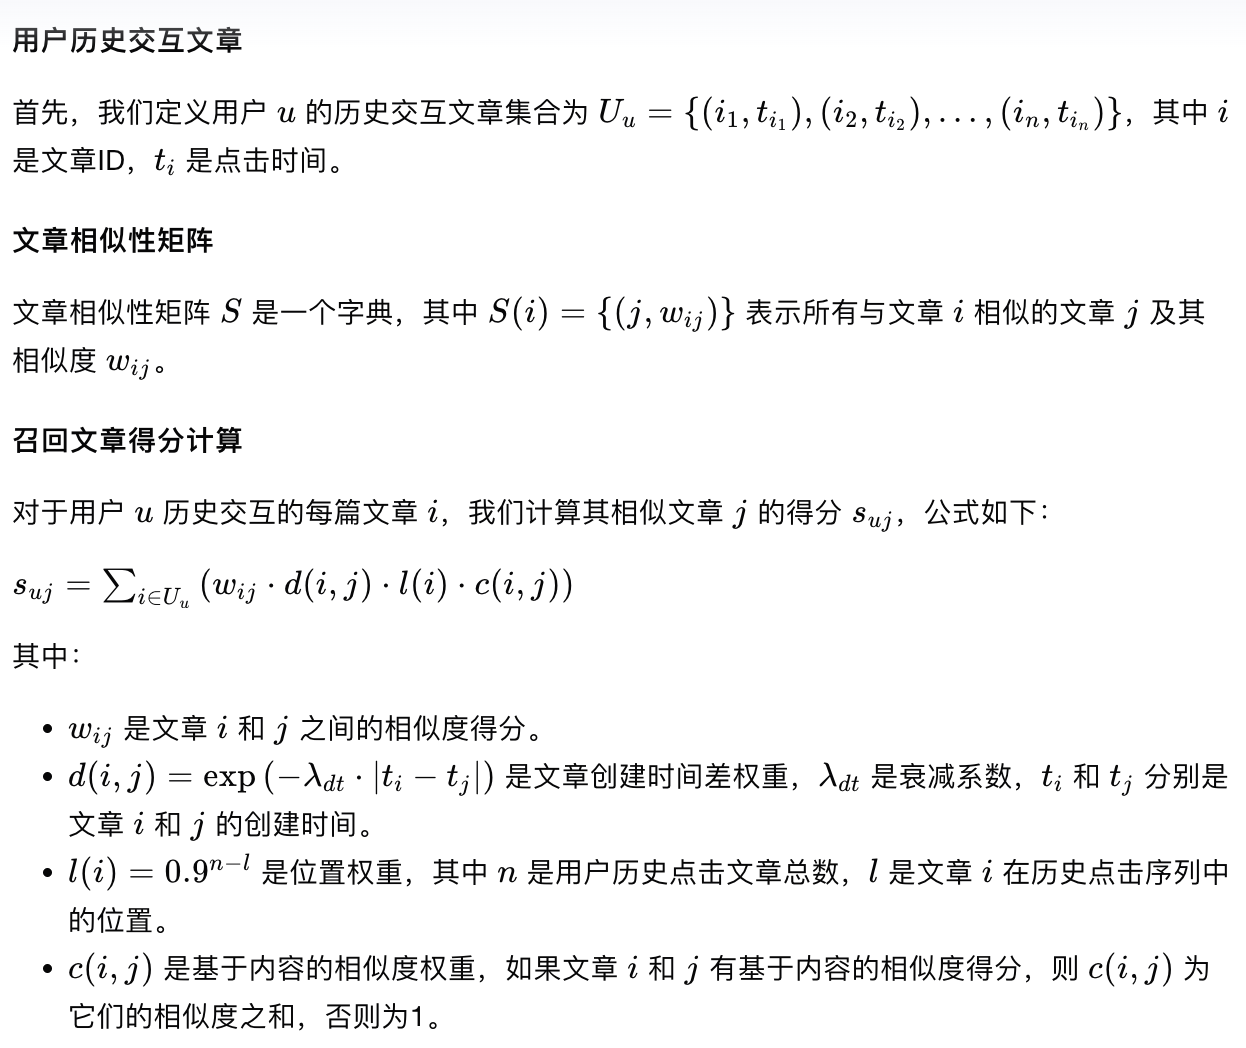

In [78]:

# 基于商品的召回i2i
def item_based_recommend(user_id, user_item_time_dict, i2i_sim, sim_item_topk, recall_item_num, item_topk_click, item_created_time_dict, emb_i2i_sim):
    """
        基于文章协同过滤的召回
        :param user_id: 用户id
        :param user_item_time_dict: 字典, 根据点击时间获取用户的点击文章序列   {user1: [(item1, time1), (item2, time2)..]...}
        :param i2i_sim: 字典，文章相似性矩阵
        :param sim_item_topk: 整数， 选择与当前文章最相似的前k篇文章
        :param recall_item_num: 整数， 最后的召回文章数量
        :param item_topk_click: 列表，点击次数最多的文章列表，用户召回补全
        :param emb_i2i_sim: 字典基于内容embedding算的文章相似矩阵
        
        return: 召回的文章列表 [(item1, score1), (item2, score2)...]
    """
    # 获取用户历史交互的文章
    user_hist_items = user_item_time_dict[user_id]
    user_hist_items_ = {user_id for user_id, _ in user_hist_items}
    
    item_rank = {}
    for loc, (i, click_time) in enumerate(user_hist_items):
        for j, wij in sorted(i2i_sim[i].items(), key=lambda x: x[1], reverse=True)[:sim_item_topk]:
            if j in user_hist_items_:
                continue
            
            # 文章创建时间差权重
            created_time_weight = np.exp(0.8 ** np.abs(item_created_time_dict[i] - item_created_time_dict[j]))
            # 相似文章和历史点击文章序列中历史文章所在的位置权重
            loc_weight = (0.9 ** (len(user_hist_items) - loc))
            
            content_weight = 1.0
            if emb_i2i_sim.get(i, {}).get(j, None) is not None:
                content_weight += emb_i2i_sim[i][j]
            if emb_i2i_sim.get(j, {}).get(i, None) is not None:
                content_weight += emb_i2i_sim[j][i]
                
            item_rank.setdefault(j, 0)
            item_rank[j] += created_time_weight * loc_weight * content_weight * wij
    
    # 不足10个，用热门商品补全
    if len(item_rank) < recall_item_num:
        for i, item in enumerate(item_topk_click):
            if item in item_rank.items(): # 填充的item应该不在原来的列表中
                continue
            item_rank[item] = - i - 100 # 随便给个负数就行
            if len(item_rank) == recall_item_num:
                break
    
    item_rank = sorted(item_rank.items(), key=lambda x: x[1], reverse=True)[:recall_item_num]
        
    return item_rank

In [98]:
# 先进行itemcf召回, 为了召回评估，所以提取最后一次点击

if metric_recall:
    trn_hist_click_df, trn_last_click_df = get_hist_and_last_click(all_click_df)
else:
    trn_hist_click_df = all_click_df

user_recall_items_dict = collections.defaultdict(dict)
user_item_time_dict = get_user_item_time(trn_hist_click_df)

i2i_sim = pickle.load(open(save_path + 'itemcf_i2i_sim.pkl', 'rb'))
emb_i2i_sim = pickle.load(open(save_path + 'emb_i2i_sim.pkl', 'rb'))

sim_item_topk = 20
recall_item_num = 10
item_topk_click = get_item_topk_click(trn_hist_click_df, k=50)

for user in tqdm(trn_hist_click_df['user_id'].unique()):
    user_recall_items_dict[user] = item_based_recommend(user, user_item_time_dict, \
                                                        i2i_sim, sim_item_topk, recall_item_num, \
                                                        item_topk_click, item_created_time_dict, emb_i2i_sim)

user_multi_recall_dict['itemcf_sim_itemcf_recall'] = user_recall_items_dict
pickle.dump(user_multi_recall_dict['itemcf_sim_itemcf_recall'], open(save_path + 'itemcf_recall_dict.pkl', 'wb'))

if metric_recall:
    # 召回效果评估
    metrics_recall(user_multi_recall_dict['itemcf_sim_itemcf_recall'], trn_last_click_df)

100%|██████████| 500/500 [00:00<00:00, 957.61it/s] 


### userCF召回
基于用户协同过滤，核心思想是给用户推荐与其相似的用户历史点击文章。<br>
这里使用的关联规则是考虑相似用户的历史点击文章与被推荐用户历史点击商品的关系权重。

1. 计算被推荐用户历史点击文章与相似用户历史点击文章的相似度，文章创建时间差，相对位置的总和，作为各自的权重

In [102]:
def user_based_recommend(user_id,user_item_time_dict,u2u_sim,sim_user_topk,recall_item_num,item_topk_click,item_created_time_dict,emb_i2i_sim):
    """
        基于文章协同过滤的召回
        user_id: 用户id
        user_item_time_dict: 字典，键是用户ID，值是用户点击过的文章ID和点击时间的列表，根据点击时间获取用户的点击文章序列 {user1:{item1:time1,item2:time2,...}}
        u2u_sim: 字典，文章相似性矩阵，键是用户ID，值是与其他用户相似度的字典
        sim_user_topk: 整数，选择与当前用户最相似的前k个用户
        recall_item_num: 整数，最后的召回文章数量
        item_topk_click: 列表，点击次数最多的文章列表，用户召回补全
        item_created_time_click: 字典，文章创建时间列表，键是文章ID，值是文章的创建时间
        emb_i2i_sim: 字典，基于内容embedding算的文章相似性矩阵

        return：召回的文章列表 {item1:score1,item2:score2,...}
    """
    # 获取用户历史交互的文章
    user_item_time_list=user_item_time_dict[user_id]
    user_hist_items=set([i for i,t in user_item_time_list]) # 存在一个用户与某篇文章的多次交互

    # 初始化召回文章的得分字典
    items_rank={}
    # 遍历相似用户的文章（与目标用户相似度最高的sim_user_topk个用户）
    for sim_u, wuv in sorted(u2u_sim[user_id].items(),key=lambda x:x[1],reverse=True)[:sim_user_topk]:
        """
            sim_u: 相似用户
            wuv: 相似用户权重（用户u与用户v的相似度）
        """
        for i, click_time in user_item_time_dict[sim_u]:
            if i in user_hist_items:
                continue
            items_rank.setdefault(i,0)

            loc_weight=1.0 # 点击时的相似位置权重（这里简单的将所有位置的权重设置为1）
            content_weight=1.0 # 内容相似性权重，如果文章i与目标用户历史点击的文章j在内容上相似，则增加权重
            created_time_weight=1.0 # 创建时间差权重（时间差越大，权重越小）

            # 当前文章与该用户看的历史文章进行一个权重交互
            for loc,(j,click_time) in enumerate(user_item_time_list):
                # 点击时的相对位置权重
                loc_weight+=0.9**(len(user_item_time_list)-loc)
                
                # 内容相似性权重
                # 如果文章i与目标用户历史点击的文章j在内容上相似，则增加权重
                if emb_i2i_sim.get(i,{}).get(j,None) is not None:
                    content_weight+=emb_i2i_sim[i][j]
     
                if emb_i2i_sim.get(j,{}).get(i,None) is not None:
                    content_weight+=emb_i2i_sim[j][i]


                # 创建时间差权重
                created_time_weight+=np.exp(0.8*np.abs(item_created_time_dict[i]-item_created_time_dict[j]))

            items_rank[i]+=loc_weight*content_weight*created_time_weight*wuv

    # 热度补全
    if len(items_rank)<recall_item_num:
        for i,item in enumerate(item_topk_click):
            if item in items_rank.items():
                continue
            items_rank[item]=-i-100 
            if len(items_rank)==recall_item_num:
                break
                    
    # 对召回文章进行排序并返回（对召回文章按照得分进行降序排序，并且返回得分最高的前recall_item_num篇文章）
    items_rank=sorted(items_rank.items(),key=lambda x:x[1],reverse=True)[:recall_item_num]

    return items_rank

In [103]:
if metric_recall:
    trn_hist_click_df,trn_last_click_df=get_hist_and_last_click(all_click_df)
else:
    trn_hist_click_df=all_click_df

user_recall_items_dict=collections.defaultdict(dict)
user_item_time_dict=get_user_item_time(trn_hist_click_df)

u2u_sim=pickle.load(open(save_path+'usercf_u2u_sim.pkl','rb'))

sim_user_topk=20
recall_item_num=10
item_topk_click=get_item_topk_click(trn_hist_click_df,k=50)

for user in tqdm(trn_hist_click_df['user_id'].unique()):
    user_recall_items_dict[user]=user_based_recommend(user,user_item_time_dict,u2u_sim,sim_user_topk,recall_item_num,item_topk_click,item_created_time_dict,emb_i2i_sim)

pickle.dump(user_recall_items_dict,open(save_path+'usercf_u2u2i_recall.pkl','wb'))

if metric_recall:
    # 召回效果评估
    metrics_recall(user_recall_items_dict,trn_last_click_df,topk=recall_item_num)

100%|██████████| 500/500 [00:03<00:00, 151.49it/s]


## 冷启动
1. 文章冷启动：对于一个平台系统新加入的文章，该文章没有任何的交互记录，如何推荐给用户。（日志数据中没有出现过的文章都可以认为是冷启动的文章）
2. 用户冷启动：对于一个平台系统新来的用户，该用户还没有文章的交互信息，如何给用户进行推荐。（测试集中的用户是否在测试集对应的log数据中吹安国，如果没有出现过，则可以认为该用户是冷启动用户）
3. 系统冷启动：对于一个平台刚上线，没有任何的相关历史数据，此时就是系统冷启动。

In [104]:
# 先进行itemcf召回
trn_hist_click_df=all_click_df

user_recall_items_dict=collections.defaultdict(dict)
user_item_time_dict=get_user_item_time(trn_hist_click_df)
i2i_sim=pickle.load(open(save_path+'emb_i2i_sim.pkl','rb'))

sim_item_topk=150
recall_item_num=100 # 召回的文章数量

item_topk_click=get_item_topk_click(trn_hist_click_df,k=50)
for user in tqdm(trn_hist_click_df['user_id'].unique()):
    user_recall_items_dict[user]=item_based_recommend(user,user_item_time_dict,i2i_sim,sim_item_topk,recall_item_num,item_topk_click,item_created_time_dict,emb_i2i_sim)
pickle.dump(user_recall_items_dict,open(save_path+'cold_start_items_raw_dict.pkl','wb'))

100%|██████████| 500/500 [00:00<00:00, 891.11it/s] 


In [108]:
# 基于规则进行文章过滤
# 保留文章主题与用户历史浏览主题相似的文章
# 保留文章字数与用户历史浏览文章字数相差不大的文章
# 保留最后一次点击当天的文章
# 按照相似度返回最终的结果

def get_click_article_ids_set(all_click_df):
    return set(all_click_df.click_article_id.values)

def cold_start_items(user_recall_items_dict,user_hist_item_typs_dict,user_hist_item_words_dict,\
                    user_last_item_created_time_dict,item_type_dict,item_words_dict,
                    item_created_time_dict,click_article_ids_set,recall_item_num):
    """
        冷启动的情况下召回一些文章
        :param user_recall_items_dict: 基于内容embedding相似性召回来的文章字典，{user1:[(item1,item2),...],...}
        :param user_hist_item_typs_dict: 字典，用户点击的文章的主题映射
        :param user_hist_item_words_dict: 字典，用户点击的历史文章的字数映射
        :param user_last_item_created_time_dict: 字典，用户点击的历史文章创建时间映射
        :param item_type_dict: 字典，文章主题映射
        :param item_words_dict: 字典，文章字数映射
        :param item_created_time_dict: 字典，文章创建时间映射
        :param click_article_ids_set: 集合，用户点击过的文章，也就是日志里面出现过的文章
        :param recall_item_num: 召回文章的数量（指的是没有出现在日志里面的文章数量） 
    """
    cold_start_user_items_dict={}
    for user,item_list in tqdm(user_recall_items_dict.items()):
        cold_start_user_items_dict.setdefault(user,[])
        for item,score in item_list:
            # 获取历史文章信息
            hist_item_type_set=user_hist_item_typs_dict[user]
            hist_mean_words=user_hist_item_words_dict[user]
            hist_last_item_created_time=user_last_item_created_time_dict[user]                
            hist_last_item_created_time=datetime.fromtimestamp(hist_last_item_created_time)
                
            # 获取当前召回文章的信息
            curr_item_type=item_type_dict[item]
            curr_item_words=item_words_dict[item]
            curr_item_created_time=item_created_time_dict[item]
            curr_item_created_time=datetime.fromtimestamp(curr_item_created_time)
                
            # 文章不能出现在用户的历史点击中，然后根据文章主题，文章单词数，文章创建时间进行筛选
            if curr_item_type not in hist_item_type_set or \
                item in click_article_ids_set or \
                abs(curr_item_words-hist_mean_words)>200 or \
                abs((cur_item_created_time-hist_last_item_created_time).days)>90:
                continue
                    
            cold_start_user_items_dict[user].append((item,score))
            
        # 控制冷启动召回的数量
        cold_start_user_items_dict={k: sorted(v,key=lambda x: x[1],reverse=True)[:recall_item_num]\
                                        for k,v in cold_start_user_items_dict.items()}
            
        pickle.dump(cold_start_user_items_dict,open(save_path+'cold_start_user_items_dict.pkl','wb'))
        return cold_start_user_items_dict

In [109]:
all_click_df_=all_click_df.copy()
all_click_df_=all_click_df_.merge(item_info_df,how='left',on='click_article_id')
user_hist_item_typs_dict,user_hist_item_ids_dict,user_hist_item_words_dict,user_last_item_created_time_dict=get_user_hist_item_info_dict(all_click_df_)
click_article_ids_set = get_click_article_ids_set(all_click_df)
# 需要注意的是
# 这里使用了很多规则来筛选冷启动的文章，所以前面再召回的阶段就应该尽可能的多召回一些文章，否则很容易被删掉
cold_start_user_items_dict = cold_start_items(user_recall_items_dict, user_hist_item_typs_dict, user_hist_item_words_dict, \
                                              user_last_item_created_time_dict, item_type_dict, item_words_dict, \
                                              item_created_time_dict, click_article_ids_set, recall_item_num)

user_multi_recall_dict['cold_start_recall'] = cold_start_user_items_dict

  0%|          | 0/500 [00:00<?, ?it/s]


ValueError: Invalid value NaN (not a number)